
# Comparison of Calibration of Classifiers

Well calibrated classifiers are probabilistic classifiers for which the output
of :term:`predict_proba` can be directly interpreted as a confidence level.
For instance, a well calibrated (binary) classifier should classify the samples
such that for the samples to which it gave a :term:`predict_proba` value close
to 0.8, approximately 80% actually belong to the positive class.

In this example we will compare the calibration of four different
models: `Logistic_regression`, `gaussian_naive_bayes`,
`Random Forest Classifier <forest>` and `Linear SVM
<svm_classification>`.


Authors: The scikit-learn developers
SPDX-License-Identifier: BSD-3-Clause



In [1]:
#
# Dataset
# -------
#
# We will use a synthetic binary classification dataset with 100,000 samples
# and 20 features. Of the 20 features, only 2 are informative, 2 are
# redundant (random combinations of the informative features) and the
# remaining 16 are uninformative (random numbers).
#
# Of the 100,000 samples, 100 will be used for model fitting and the remaining
# for testing. Note that this split is quite unusual: the goal is to obtain
# stable calibration curve estimates for models that are potentially prone to
# overfitting. In practice, one should rather use cross-validation with more
# balanced splits but this would make the code of this example more complicated
# to follow.

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

## Calibration curves

Below, we train each of the four models with the small training dataset, then
plot calibration curves (also known as reliability diagrams) using
predicted probabilities of the test dataset. Calibration curves are created
by binning predicted probabilities, then plotting the mean predicted
probability in each bin against the observed frequency ('fraction of
positives'). Below the calibration curve, we plot a histogram showing
the distribution of the predicted probabilities or more specifically,
the number of samples in each predicted probability bin.



In [2]:
import numpy as np

from sklearn.svm import LinearSVC


class NaivelyCalibratedLinearSVC(LinearSVC):
    """LinearSVC with `predict_proba` method that naively scales
    `decision_function` output."""

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        """Min-max scale output of `decision_function` to [0,1]."""
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [3]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

# Define the classifiers to be compared in the study.
#
# Note that we use a variant of the logistic regression model that can
# automatically tune its regularization parameter.
#
# For a fair comparison, we should run a hyper-parameter search for all the
# classifiers but we don't do it here for the sake of keeping the example code
# concise and fast to execute.
lr = LogisticRegressionCV(
    Cs=np.logspace(-6, 6, 101), cv=10, scoring="neg_log_loss", max_iter=1_000
)
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0)
rfc = RandomForestClassifier(random_state=42)

clf_list = [
    (lr, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest"),
]

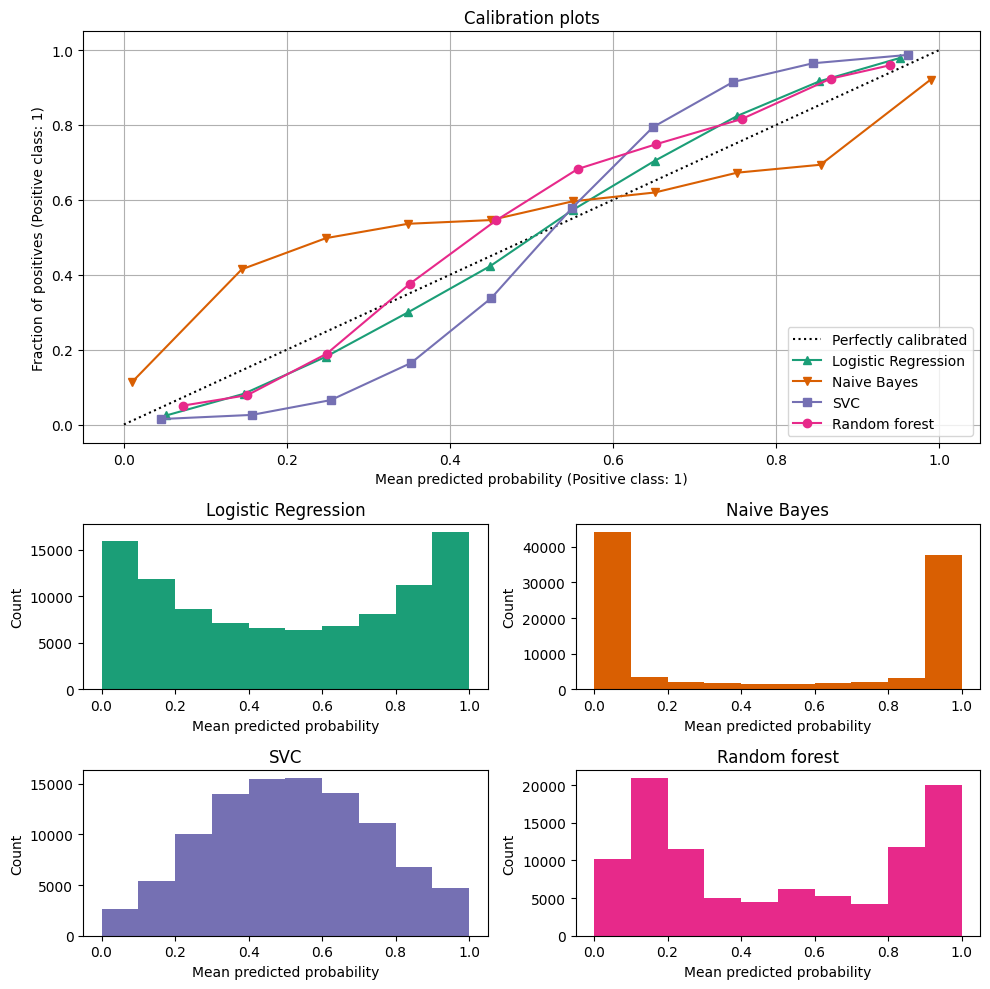

In [4]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

## Analysis of the results

:class:`~sklearn.linear_model.LogisticRegressionCV` returns reasonably well
calibrated predictions despite the small training set size: its reliability
curve is the closest to the diagonal among the four models.

Logistic regression is trained by minimizing the log-loss which is a strictly
proper scoring rule: in the limit of infinite training data, strictly proper
scoring rules are minimized by the model that predicts the true conditional
probabilities. That (hypothetical) model would therefore be perfectly
calibrated. However, using a proper scoring rule as training objective is not
sufficient to guarantee a well-calibrated model by itself: even with a very
large training set, logistic regression could still be poorly calibrated, if
it was too strongly regularized or if the choice and preprocessing of input
features made this model mis-specified (e.g. if the true decision boundary of
the dataset is a highly non-linear function of the input features).

In this example the training set was intentionally kept very small. In this
setting, optimizing the log-loss can still lead to poorly calibrated models
because of overfitting. To mitigate this, the
:class:`~sklearn.linear_model.LogisticRegressionCV` class was configured to
tune the `C` regularization parameter to also minimize the log-loss via inner
cross-validation so as to find the best compromise for this model in the
small training set setting.

Because of the finite training set size and the lack of guarantee for
well-specification, we observe that the calibration curve of the logistic
regression model is close but not perfectly on the diagonal. The shape of the
calibration curve of this model can be interpreted as slightly
under-confident: the predicted probabilities are a bit too close to 0.5
compared to the true fraction of positive samples.

The other methods all output less well calibrated probabilities:

* :class:`~sklearn.naive_bayes.GaussianNB` tends to push probabilities to 0
  or 1 (see histogram) on this particular dataset (over-confidence). This is
  mainly because the naive Bayes equation only provides correct estimate of
  probabilities when the assumption that features are conditionally
  independent holds [2]_. However, features can be correlated and this is the case
  with this dataset, which contains 2 features generated as random linear
  combinations of the informative features. These correlated features are
  effectively being 'counted twice', resulting in pushing the predicted
  probabilities towards 0 and 1 [3]_. Note, however, that changing the seed
  used to generate the dataset can lead to widely varying results for the
  naive Bayes estimator.

* :class:`~sklearn.svm.LinearSVC` is not a natural probabilistic classifier.
  In order to interpret its prediction as such, we naively scaled the output
  of the :term:`decision_function` into [0, 1] by applying min-max scaling in
  the `NaivelyCalibratedLinearSVC` wrapper class defined above. This
  estimator shows a typical sigmoid-shaped calibration curve on this data:
  predictions larger than 0.5 correspond to samples with an even larger
  effective positive class fraction (above the diagonal), while predictions
  below 0.5 corresponds to even lower positive class fractions (below the
  diagonal). This under-confident predictions are typical for maximum-margin
  methods [1]_.

* :class:`~sklearn.ensemble.RandomForestClassifier`'s prediction histogram
  shows peaks at approx. 0.2 and 0.9 probability, while probabilities close to
  0 or 1 are very rare. An explanation for this is given by [1]_:
  "Methods such as bagging and random forests that average
  predictions from a base set of models can have difficulty making
  predictions near 0 and 1 because variance in the underlying base models
  will bias predictions that should be near zero or one away from these
  values. Because predictions are restricted to the interval [0, 1], errors
  caused by variance tend to be one-sided near zero and one. For example, if
  a model should predict p = 0 for a case, the only way bagging can achieve
  this is if all bagged trees predict zero. If we add noise to the trees that
  bagging is averaging over, this noise will cause some trees to predict
  values larger than 0 for this case, thus moving the average prediction of
  the bagged ensemble away from 0. We observe this effect most strongly with
  random forests because the base-level trees trained with random forests
  have relatively high variance due to feature subsetting." This effect can
  make random forests under-confident. Despite this possible bias, note that
  the trees themselves are fit by minimizing either the Gini or Entropy
  criterion, both of which lead to splits that minimize proper scoring rules:
  the Brier score or the log-loss respectively. See `the user guide
  <tree_mathematical_formulation>` for more details. This can explain why
  this model shows a good enough calibration curve on this particular example
  dataset. Indeed the Random Forest model is not significantly more
  under-confident than the Logistic Regression model.

Feel free to re-run this example with different random seeds and other
dataset generation parameters to see how different the calibration plots can
look. In general, Logistic Regression and Random Forest will tend to be the
best calibrated classifiers, while SVC will often display the typical
under-confident miscalibration. The naive Bayes model is also often poorly
calibrated but the general shape of its calibration curve can vary widely
depending on the dataset.

Finally, note that for some dataset seeds, all models are poorly calibrated,
even when tuning the regularization parameter as above. This is bound to
happen when the training size is too small or when the model is severely
misspecified.

## References

.. [1] [Predicting Good Probabilities with Supervised Learning](https://dl.acm.org/doi/pdf/10.1145/1102351.1102430), A.
       Niculescu-Mizil & R. Caruana, ICML 2005

.. [2] [Beyond independence: Conditions for the optimality of the simple
       Bayesian classifier](https://www.ics.uci.edu/~pazzani/Publications/mlc96-pedro.pdf)
       Domingos, P., & Pazzani, M., Proc. 13th Intl. Conf. Machine Learning.
       1996.

.. [3] [Obtaining calibrated probability estimates from decision trees and
       naive Bayesian classifiers](https://cseweb.ucsd.edu/~elkan/calibrated.pdf)
       Zadrozny, Bianca, and Charles Elkan. Icml. Vol. 1. 2001.

